In [ ]:
# forked from https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style("darkgrid")

import re
import scipy.stats as ss
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, GridSearchCV
from _utils.u_constant import PATH_ROOT
path = PATH_ROOT + "Code projects/Python/kaggle/Titanic Machine Learning from Disaster/"

## 1. Data Processing

In [2]:
data_raw = pd.read_csv(path + "train.csv")
data_val = pd.read_csv(path + "test.csv")

data1 = data_raw.copy(deep=True)
data_cleaner = [data1, data_val]
combine = pd.concat([data_raw.drop("Survived", axis=1), data_val], 
                    axis=0, 
                    ignore_index=True)

test_ids = data_val["PassengerId"].values

### 1.1 Completing

In [12]:
print(data_raw.info(null_counts=True))
print("-" * 10)
print("Train columns with null values: \n", data_raw.isnull().sum())
print("-" * 10)
print("Test columns with null values: \n", data_val.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
----------
Train columns with null values: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test columns with null values: 
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age 

In [3]:
for data in data_cleaner:
    data["Age"] = data["Age"].fillna(combine["Age"].median())
    data["Embarked"] = data["Embarked"].fillna(combine["Embarked"].mode()[0])
    data["Fare"] = data["Fare"].fillna(combine["Fare"].median())
    data.drop(["PassengerId", "Cabin", "Ticket"], axis=1, inplace=True)

print(data1.isnull().sum())
print("-" * 10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


### 1.2 Creating & Converting

In [4]:
def discretize_fare(fare):
    if fare <= 7.91:
        return 0
    if fare <= 14.454:
        return 1
    if fare <= 31.0:
        return 2
    return 3

def discretize_age(age):
    if age <= 16:
        return 0
    if age <= 32:
        return 1
    if age <= 48:
        return 2
    if age <= 64:
        return 3
    return 4

def get_title(name):
    s = re.search(pattern="([A-Za-z]+)\.", string=name).group(1)
    if s is None:
        return ""
    if s in ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        return "Rare"
    if s in ["Mlle", "Ms"]:
        return "Miss"
    if s in ["Mme"]:
        return "Mrs"
    return s 

In [5]:
for data in data_cleaner:
    data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
    data["IsAlone"] = (data["FamilySize"] <= 1).astype(int)
    data["Title"] = data["Name"].apply(get_title)
    data["Title_Code"] = data["Title"]\
        .map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})\
        .fillna(0)
    data["FareBin_Code"] = data["Fare"].apply(discretize_fare)
    data["AgeBin_Code"] = data["Age"].apply(discretize_age)
    data["Sex_Code"] = data["Sex"].map({"female": 1, "male": 0}).astype(int)
    data["Embarked_Code"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)

Target = ["Survived"]
data1_x = ["Sex", "Pclass", "Embarked", "Title", "SibSp", 
           "Parch", "Age", "Fare", "FamilySize", "IsAlone"]
data1_x_calc = ["Sex_Code", "Pclass", "Embarked_Code", "Title_Code", 
                "FamilySize", "AgeBin_Code", "FareBin_Code"]
data1_xy = Target + data1_x
print("Original X Y: ", data1_xy)

data1_x_bin = ["Sex_Code", "Pclass", "Embarked_Code", "Title_Code", 
               "FamilySize", "AgeBin_Code", "FareBin_Code"]
data1_xy_bin = Target + data1_x_bin
print("Bin X Y: ", data1_xy_bin)

data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print("Dummy X Y: ", data1_xy_dummy)
data1_dummy.head(20)

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']


,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,1,0,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,1,0
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,1,0,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,1,0
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,1,0,0
5,3,0,0,28.0,8.4583,1,1,0,1,0,1,0,0,0,1,0,0
6,1,0,0,54.0,51.8625,1,1,0,1,0,0,1,0,0,1,0,0
7,3,3,1,2.0,21.0750,5,0,0,1,0,0,1,1,0,0,0,0
8,3,0,2,27.0,11.1333,3,0,1,0,0,0,1,0,0,0,1,0
9,2,1,0,14.0,30.0708,2,0,1,0,1,0,0,0,0,0,1,0


## 2. Exploring Analysis

In [6]:
train1_x, test1_x, train1_y, test1_y = \
    train_test_split(data1[data1_x_calc], data1[Target], test_size=0.25, random_state=0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = \
    train_test_split(data1[data1_x_bin], data1[Target], test_size=0.25, random_state=0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = \
    train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state=0)

print("Data1 shape: ", data1.shape)
print("Train1 shape: ", train1_x.shape)
print("Test1 shape: ", test1_x.shape)

Data1 shape:  (891, 17)
Train1 shape:  (668, 7)
Test1 shape:  (223, 7)


In [30]:
# Discrete Variable Correction by Survival using pivot table
for col in data1_x:
    if data1[col].dtype != 'float64':
        print("Survival Correlation by: ", col)
        print(data1[[col] + Target].groupby(col, as_index=False).mean())
        print("-" * 10, "\n")

Survival Correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by:  Title
    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826
---------- 

Survival Correlation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by:  FamilySize
   FamilySize  Survived
0           1  0.30

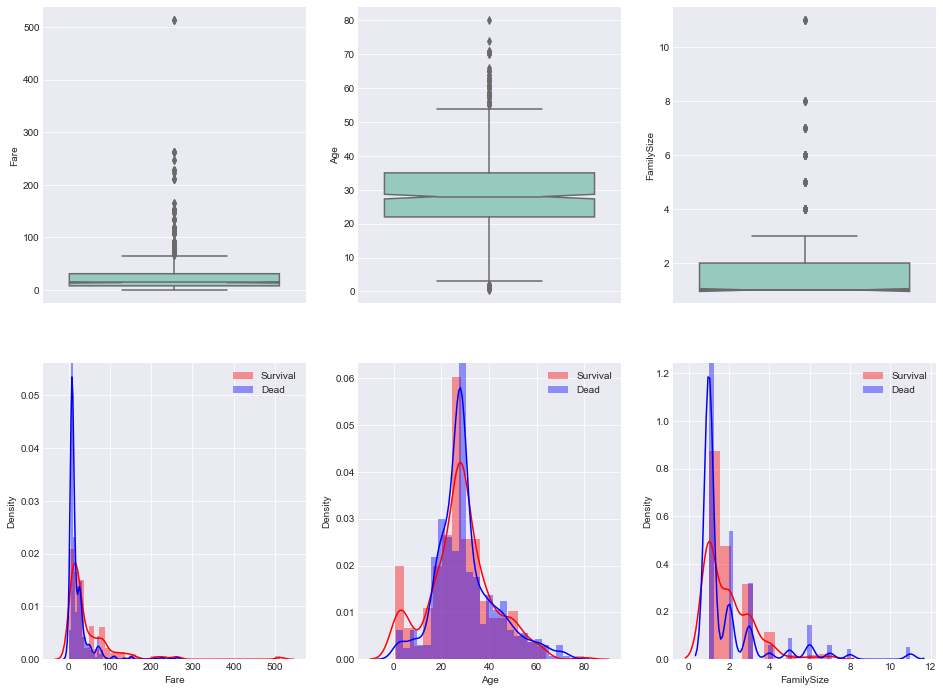

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))
for i, col in enumerate(["Fare", "Age", "FamilySize"]):
    sns.boxplot(x=None, y=col, hue=None, data=data1, palette="Set3", notch=True, ax=axes[0, i])
    cond = data1["Survived"] == 1
    g = sns.distplot(data1[cond][col], color="red", kde=True, hist=True, ax=axes[1, i])
    g = sns.distplot(data1[~cond][col], color="blue", kde=True, hist=True, ax=g)
    g.set_xlabel(col)
    g.set_ylabel("Density")
    g = g.legend(["Survival", "Dead"])
fig.show()

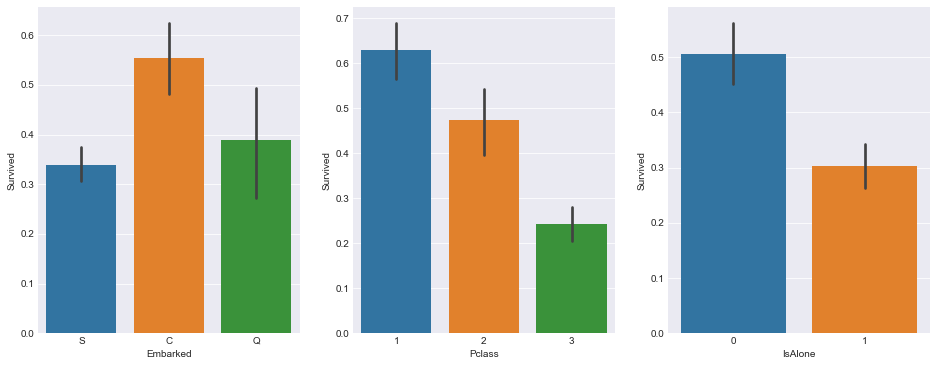

In [46]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
for i, col in enumerate(["Embarked", "Pclass", "IsAlone"]):
    sns.barplot(x=col, y="Survived", data=data1, ax=axes[i])
fig.show()

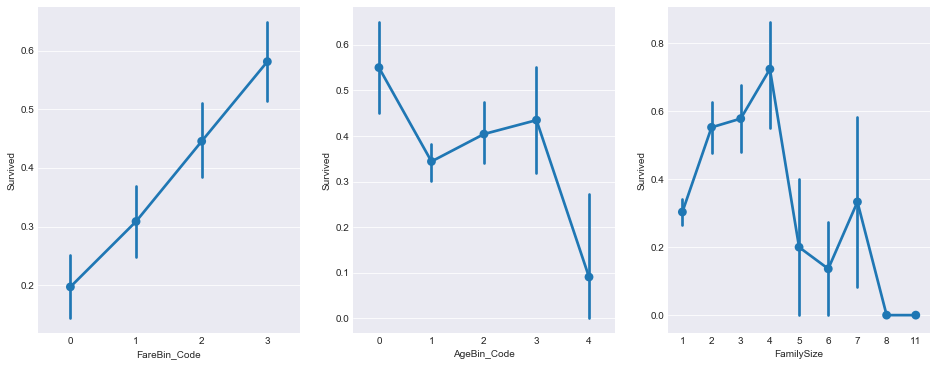

In [47]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
for i, col in enumerate(["FareBin_Code", "AgeBin_Code", "FamilySize"]):
    sns.pointplot(x=col, y="Survived", data=data1, ax=axes[i])
fig.show()

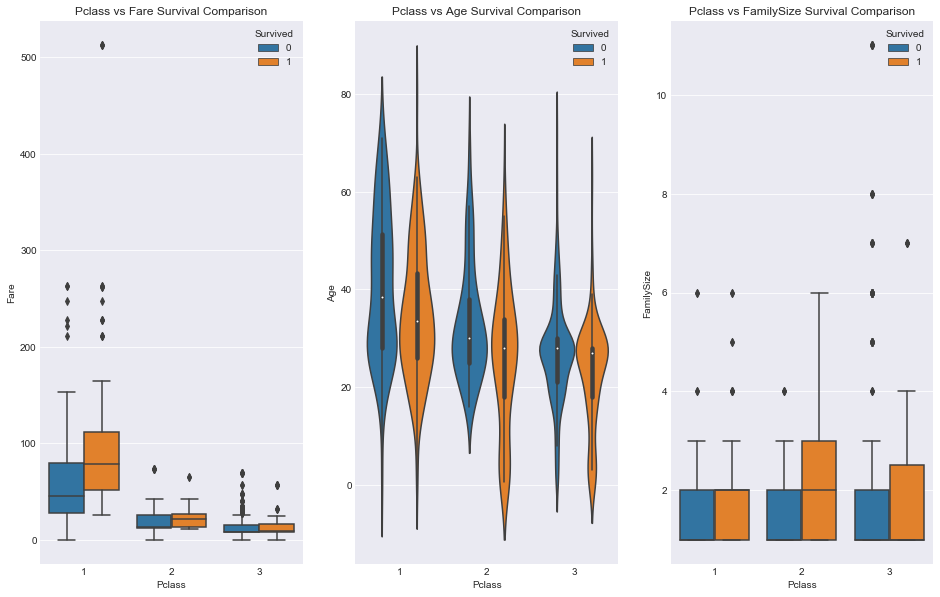

In [48]:
# Pclass vs other features
fig, axes = plt.subplots(ncols=3, figsize=(16, 10))
for i, col in enumerate(["Fare", "Age", "FamilySize"]):
    ax = axes[i]
    if col == "Age":
        g = sns.violinplot(x="Pclass", y=col, hue="Survived", data=data1, ax=ax)
    else:
        g = sns.boxplot(x="Pclass", y=col, hue="Survived", data=data1, ax=ax)
    g.set_title("Pclass vs %s Survival Comparison" % col)
fig.show()

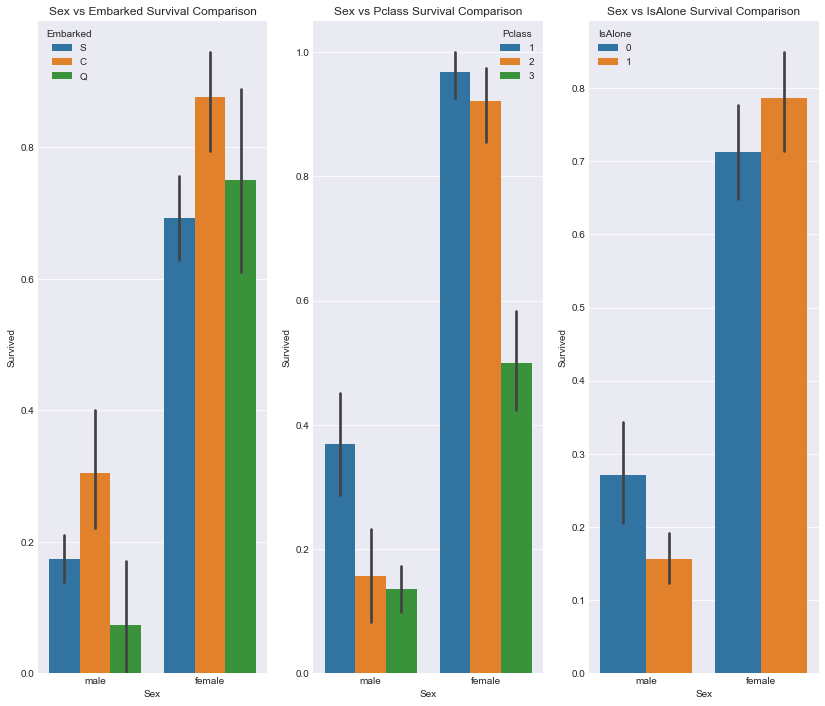

In [49]:
# graph distribution of qualitative data: Sex
# compare sex with other features
fig, axes = plt.subplots(ncols=3, figsize=(14, 12))
for i, col in enumerate(["Embarked", "Pclass", "IsAlone"]):
    ax = axes[i]
    g = sns.barplot(x="Sex", y="Survived", hue=col, data=data1, ax=ax)
    g.set_title("Sex vs %s Survival Comparison" % col)
fig.show()

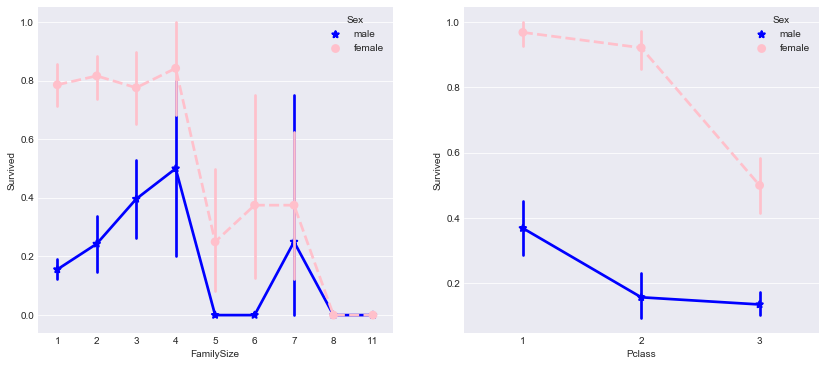

In [52]:
# more side-by-side comparisons
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
for i, col in enumerate(["FamilySize", "Pclass"]):
    ax = axes[i]
    sns.pointplot(x=col, y="Survived", hue="Sex", data=data1, 
                  palette={"male": "blue", "female": "pink"}, 
                  markers=["*", "o"], linestyles=["-", "--"], ax=ax)
fig.show()

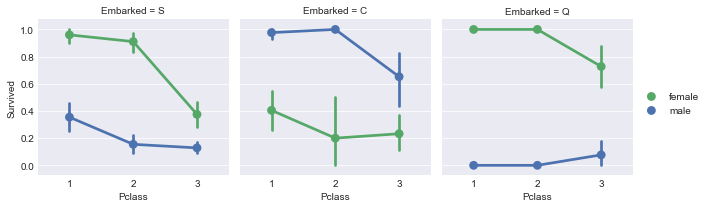

In [55]:
# embark port factor with sex, pclass and survival
e = sns.FacetGrid(data=data1, col="Embarked")
e.map(sns.pointplot, "Pclass", "Survived", "Sex", ci=95.0, palette="deep")
e.add_legend()

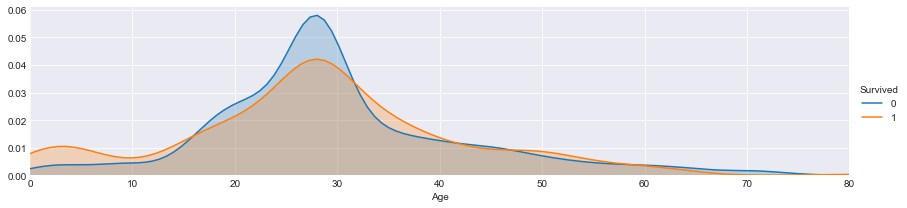

In [59]:
# plot distributions of age of passenger who survived
a = sns.FacetGrid(data=data1, hue="Survived", aspect=4)
a.map(sns.kdeplot, "Age", shade=True)
a.set(xlim=(0, 80))
a.add_legend()

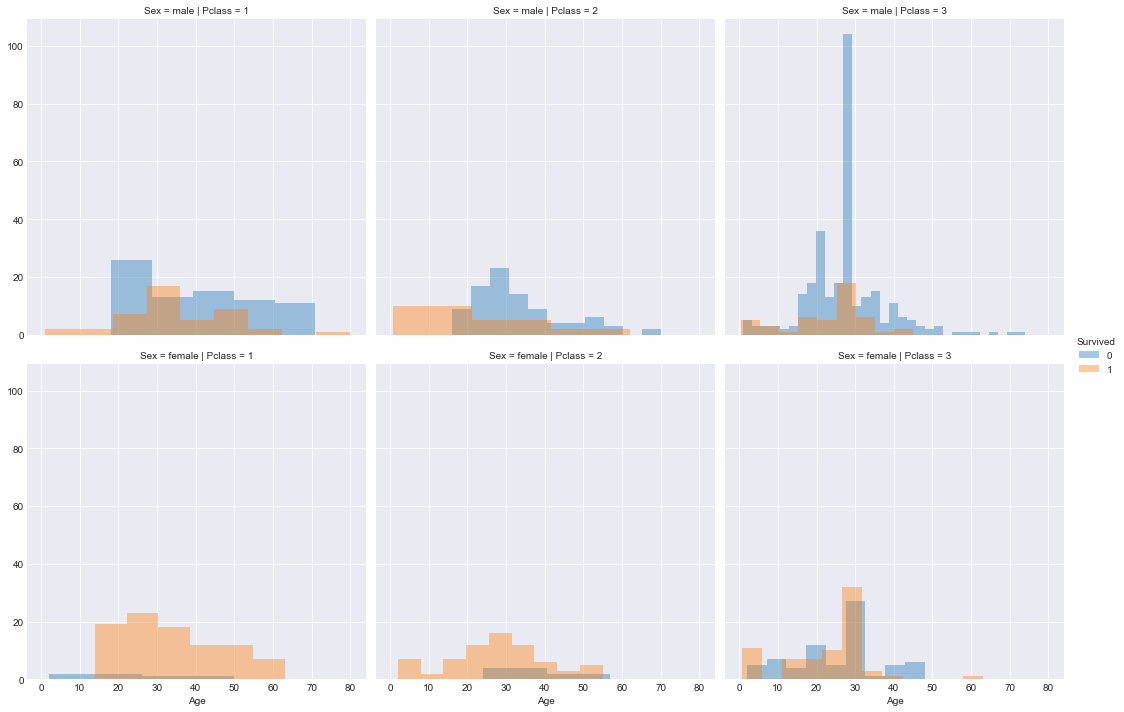

In [62]:
# histogram comparison of sex, class and age by survival
h = sns.FacetGrid(data=data1, row="Sex", col="Pclass", hue="Survived", size=5)
h.map(sns.distplot, "Age", kde=False)
h.add_legend()

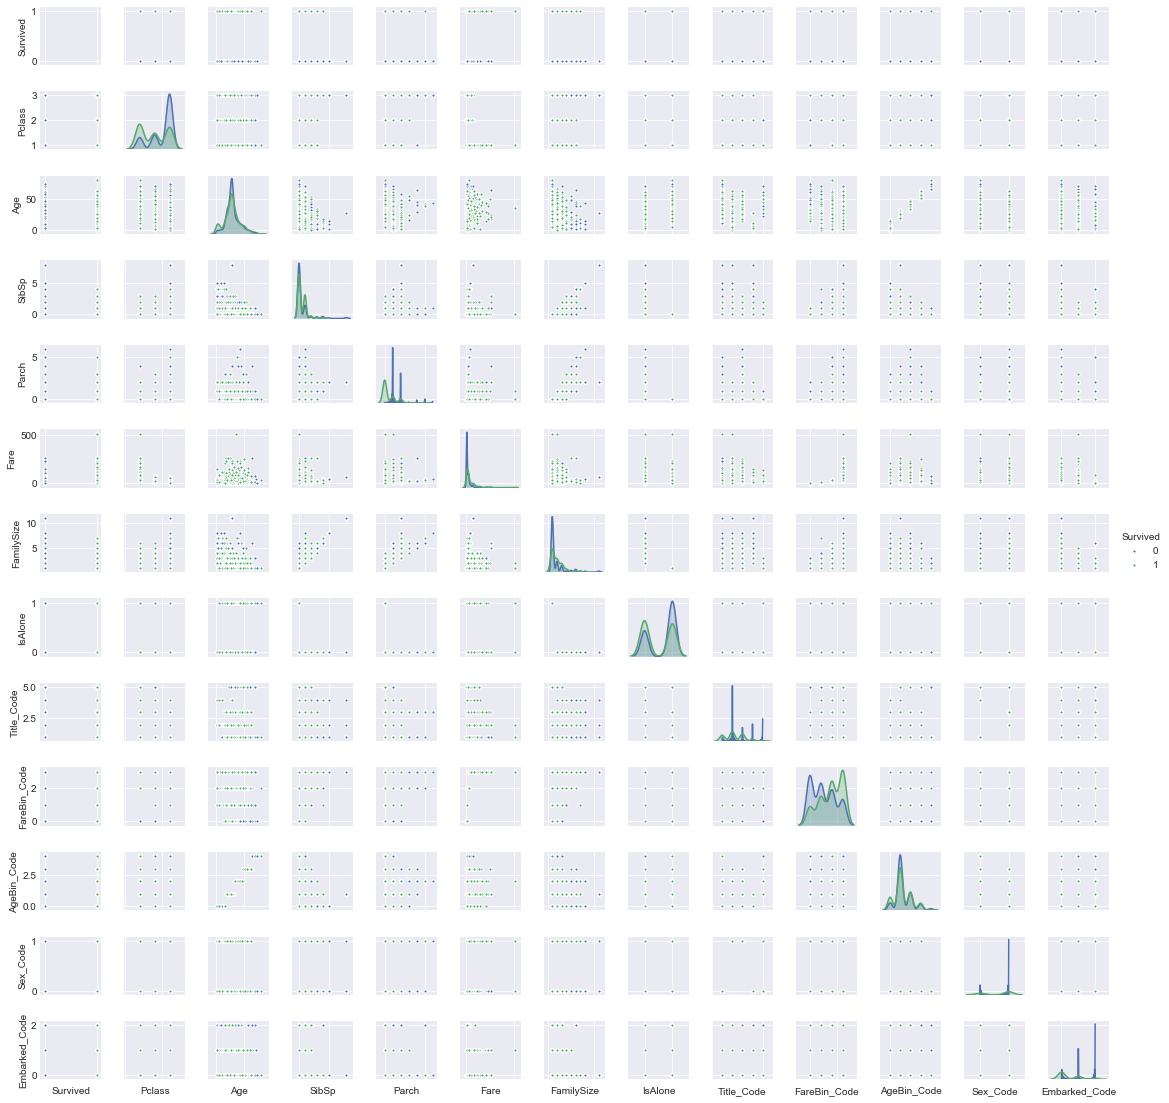

In [63]:
# pair plot for entire set
pp = sns.pairplot(data=data1, hue="Survived", palette="deep", 
                  size=1.2, diag_kind="kde", diag_kws={"shade": True}, 
                  plot_kws={"s": 10})
pp.set(xticklabels=[])

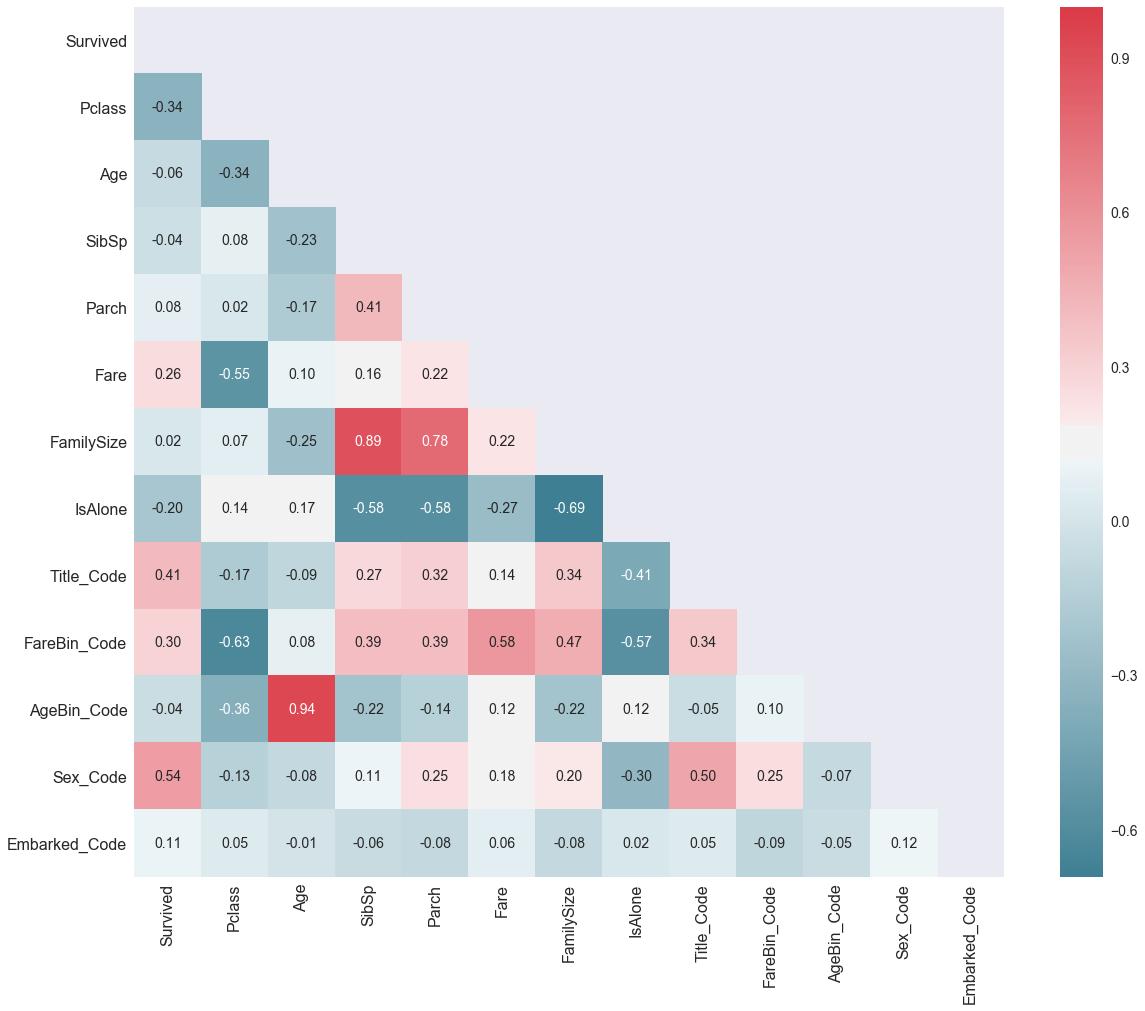

In [71]:
# corr heat map
fig, axe = plt.subplots(figsize=(20, 16))
rc = {'font.size': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
sns.set(rc=rc)
corrmat = data1.corr()
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True)
g = sns.heatmap(corrmat, mask=mask, cmap=cmap, square=True, 
                annot=True, annot_kws={"fontsize": 14},
                fmt="0.2f", ax=axe)
fig.show()

## 3. Model Data

### 3.1 BaseLine

In [7]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, \
    ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier, \
    RidgeClassifierCV, SGDClassifier, Perceptron
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

In [8]:
MLA = [
    # ensemble method
    AdaBoostClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    
    # Gaussian Processes
    GaussianProcessClassifier(),
    
    # GLM
    LogisticRegressionCV(),
    PassiveAggressiveClassifier(),
    RidgeClassifierCV(),
    SGDClassifier(),
    Perceptron(),
    
    # Naive Bayes
    BernoulliNB(),
    GaussianNB(),
    
    # NN
    KNeighborsClassifier(),
    
    # svm
    SVC(probability=True),
    NuSVC(probability=True),
    LinearSVC(),
    
    # Trees
    DecisionTreeClassifier(),
    ExtraTreesClassifier(),
    
    # Discriminant Analysis
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    
    # xgb
    XGBClassifier()
]

In [9]:
# an alternative to train_test_split
# run model 10x with 60/30 split intentionally leaving out 10%
cv_split = ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)

In [18]:
X = data1[data1_x_bin]
y = data1[Target]
MLA_columns = ["name", "parameter", "train acc mean", "test acc mean", "test acc 3*std", "time"]
MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predict = data1[Target]

for index, alg in enumerate(MLA):
    name = alg.__class__.__name__
    MLA_compare.loc[index, "name"] = name
    MLA_compare.loc[index, "parameter"] = str(alg.get_params())
    
    cv_results = cross_validate(estimator=alg, X=X, y=y, cv=cv_split)
    MLA_compare.loc[index, "time"] = cv_results["fit_time"].mean()
    MLA_compare.loc[index, "train acc mean"] = cv_results["train_score"].mean()
    MLA_compare.loc[index, "test acc mean"] = cv_results["test_score"].mean()
    MLA_compare.loc[index, "test acc 3*std"] = cv_results["test_score"].std() * 3
    
    alg.fit(X, y)
    MLA_predict[name] = alg.predict(X)
    print("index: %d, name: %s finished!" % (index, name))

MLA_compare.sort_values(by="test acc mean", ascending=False, inplace=True)
MLA_compare    

index: 0, name: AdaBoostClassifier finished!
index: 1, name: BaggingClassifier finished!
index: 2, name: ExtraTreesClassifier finished!
index: 3, name: GradientBoostingClassifier finished!
index: 4, name: RandomForestClassifier finished!
index: 5, name: GaussianProcessClassifier finished!
index: 6, name: LogisticRegressionCV finished!
index: 7, name: PassiveAggressiveClassifier finished!
index: 8, name: RidgeClassifierCV finished!
index: 9, name: SGDClassifier finished!
index: 10, name: Perceptron finished!
index: 11, name: BernoulliNB finished!
index: 12, name: GaussianNB finished!
index: 13, name: KNeighborsClassifier finished!
index: 14, name: SVC finished!
index: 15, name: NuSVC finished!
index: 16, name: LinearSVC finished!
index: 17, name: DecisionTreeClassifier finished!
index: 18, name: ExtraTreesClassifier finished!
index: 19, name: LinearDiscriminantAnalysis finished!
index: 20, name: QuadraticDiscriminantAnalysis finished!
index: 21, name: XGBClassifier finished!


,name,parameter,train acc mean,test acc mean,test acc 3*std,time
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.891386,0.83097,0.0439428,0.0100326
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895506,0.829851,0.0506089,0.0120279
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.870787,0.826866,0.0431224,0.137042
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.836704,0.826866,0.0462084,0.0362948
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.892322,0.825373,0.0606547,0.0131331
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.831835,0.824254,0.0501737,0.0397398
18,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895506,0.823881,0.0628861,0.0103273
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.855993,0.823507,0.0480301,0.117241
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.865169,0.820522,0.0607888,0.067483
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895506,0.820522,0.0457314,0.00291462


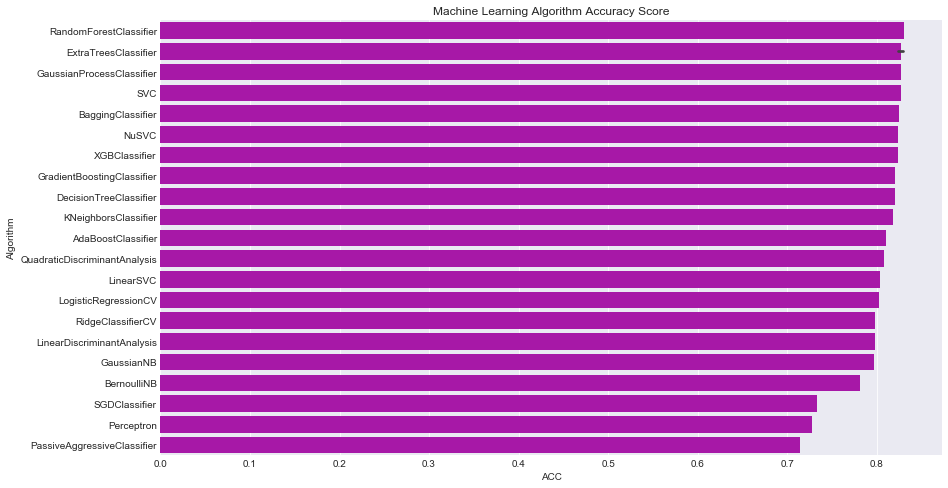

In [20]:
fig, axe = plt.subplots(figsize=(14, 8))
g = sns.barplot("test acc mean", "name", data=MLA_compare, color="m", ax=axe)
g.set_title("Machine Learning Algorithm Accuracy Score")
g.set_xlabel("ACC")
g.set_ylabel("Algorithm")
fig.show()

### 3.2 Tune Model

#### 3.2.1 Tune with Hyper-Parameters

In [27]:
# base model
dtree = DecisionTreeClassifier(random_state=0)
base_results = cross_validate(dtree, X, y, cv=cv_split)
dtree.fit(X, y)
print("Before DT Parameters: ", dtree.get_params())
print("Before DT Training w/bin score mean: %.2f" % (base_results["train_score"].mean() * 100))
print("Before DT Test w/bin score mean: %.2f" % (base_results["test_score"].mean() * 100))
print("Before DT Test w/bin score 3*std: +/- %.2f" % (base_results["test_score"].std() * 100 * 3))
print("-" * 10)

# tune model
params = {"criterion": ["gini", "entropy"], 
          "max_depth": [2, 4, 6, 8, 10, None], 
          "random_state": [0]}
g = GridSearchCV(estimator=dtree, param_grid=params, scoring="roc_auc", cv=cv_split)
g.fit(X, y)
best_index = g.best_index_
print("After DT Parameters: ", g.best_params_)
print("After DT Training w/bin score mean: %.2f" % (g.cv_results_["mean_train_score"][best_index] * 100))
print("After DT Test w/bin score mean: %.2f" % (g.cv_results_["mean_test_score"][best_index] * 100))
print("After DT Test w/bin score 3*std: +/- %.2f" % (g.cv_results_["std_test_score"][best_index] * 100* 3))
print("-" * 10)


Before DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Before DT Training w/bin score mean: 89.55
Before DT Test w/bin score mean: 82.01
Before DT Test w/bin score 3*std: +/- 5.05
----------
After DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
After DT Training w/bin score mean: 89.48
After DT Test w/bin score mean: 87.38
After DT Test w/bin score 3*std: +/- 7.05
----------


#### 3.2.2 Tune with Feature-Selection

In [28]:
from sklearn.feature_selection import RFECV

In [32]:
print("Before DT RFE Training Shape Old: ", X.shape)
print("Before DT RFE Training Columns Old: ", X.columns.values)
print("Before DT Training w/bin score mean: %.2f" % (base_results["train_score"].mean() * 100))
print("Before DT Test w/bin score mean: %.2f" % (base_results["test_score"].mean() * 100))
print("Before DT Test w/bin score 3*std: +/- %.2f" % (base_results["test_score"].std() * 100 * 3))
print("-" * 10)

dtree_rfe = RFECV(dtree, step=1, scoring="accuracy", cv=cv_split)
dtree_rfe.fit(X, y)
rfe_columns = X.columns.values[dtree_rfe.get_support()]
X_rfe = X[rfe_columns]
rfe_results = cross_validate(dtree, X=X_rfe, y=y, cv=cv_split)

print("After DT RFE Training Shape New: ", X_rfe.shape)
print("After DT RFE Training Columns New: ", rfe_columns)
print("After DT RFE Training w/bin score mean: %.2f" % (rfe_results["train_score"].mean() * 100))
print("After DT RFE Test w/bin score mean: %.2f" % (rfe_results["test_score"].mean() * 100))
print("After DT RFE Test w/bin score 3*std: +/- %.2f" % (rfe_results["test_score"].std() * 100 * 3))
print("-" * 10)

Before DT RFE Training Shape Old:  (891, 7)
Before DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
Before DT Training w/bin score mean: 89.55
Before DT Test w/bin score mean: 82.01
Before DT Test w/bin score 3*std: +/- 5.05
----------
After DT RFE Training Shape New:  (891, 6)
After DT RFE Training Columns New:  ['Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
After DT RFE Training w/bin score mean: 89.55
After DT RFE Test w/bin score mean: 81.90
After DT RFE Test w/bin score 3*std: +/- 4.83
----------


#### 3.2.3 Combine Hyper-parameter-tuning and Feature-selection

In [33]:
rfe_tune_g = GridSearchCV(dtree, param_grid=params, scoring="roc_auc", cv=cv_split)
rfe_tune_g.fit(X_rfe, y)

rfe_tune_best_index = rfe_tune_g.best_index_
print("After DT RFE Tuned Parameters: ", rfe_tune_g.best_params_)
print("After DT RFE Tuned Training w/bin score mean: %.2f" % 
      (rfe_tune_g.cv_results_["mean_train_score"][rfe_tune_best_index] * 100))
print("After DT RFE Tuned Test w/bin score mean: %.2f" % 
      (rfe_tune_g.cv_results_["mean_test_score"][rfe_tune_best_index] * 100))
print("After DT RFE Tuned Test w/bin score 3*std: +/- %.2f" % 
      (rfe_tune_g.cv_results_["std_test_score"][rfe_tune_best_index] * 100 * 3))
print("-" * 10)

After DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
After DT RFE Tuned Training w/bin score mean: 89.83
After DT RFE Tuned Test w/bin score mean: 87.15
After DT RFE Tuned Test w/bin score 3*std: +/- 7.53
----------


## 4. Submission

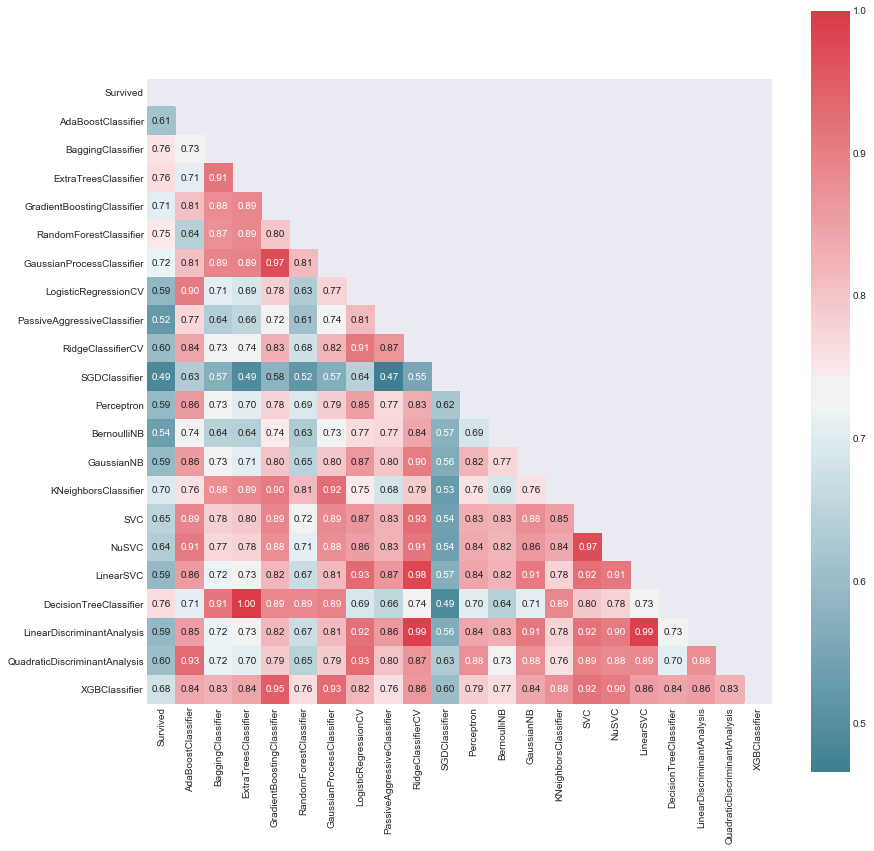

In [39]:
# corr heatmap for MLA
fig, axe = plt.subplots(figsize=(14, 14))
corrmat =  MLA_predict.corr()
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(h_pos=10, h_neg=220, as_cmap=True)
sns.heatmap(corrmat, cmap=cmap, mask=mask, annot=True, square=True, fmt="0.2f", ax=axe)
fig.show()

In [61]:
vote_est = [
    # Ensemble Methods
    ("ada", AdaBoostClassifier()),
    ("bc", BaggingClassifier()),
    ("etc", ExtraTreesClassifier()),
    ("gbc", GradientBoostingClassifier()),
    ("rfc", RandomForestClassifier()),
    ("xgb", XGBClassifier()),
    
    # Gaussian Processes
    ("gpc", GaussianProcessClassifier()),
    
    # GLM
    ("lr", LogisticRegressionCV()),
    
    # Navies Bayes
    ("bnb", BernoulliNB()),
    ("gnb", GaussianNB()),
    
    # Nearest Neighbor
    ("knn", KNeighborsClassifier()),
    
    # SVM
    ("svc", SVC(probability=True))   
]

from sklearn.ensemble import VotingClassifier
voting_model = {}
for voting in ["Hard", "Soft"]:
    vote = VotingClassifier(estimators=vote_est, voting=voting.lower())
    vote_cv = cross_validate(vote, X, y, cv=cv_split)
    vote.fit(X, y)
    voting_model[voting.lower()] = vote
    print("%s Voting Training w/bin score mean: %.2f" % (voting, vote_cv["train_score"].mean() * 100))
    print("%s Voting Test w/bin score mean: %.2f" % (voting, vote_cv["test_score"].mean() * 100))
    print("%s Voting Test w/bin score 3*std: +/- %.2f" % (voting, vote_cv["test_score"].std() * 100 * 3))
    print("-" * 10)


Hard Voting Training w/bin score mean: 86.14
Hard Voting Test w/bin score mean: 82.87
Hard Voting Test w/bin score 3*std: +/- 3.76
----------
Soft Voting Training w/bin score mean: 87.10
Soft Voting Test w/bin score mean: 82.95
Soft Voting Test w/bin score 3*std: +/- 3.65
----------


In [67]:
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [0.1, 0.25, 0.5, 0.75, 1]
grid_learn = [0.01, 0.03, 0.05, 0.1, 0.25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, 0.03, 0.05, 0.1]
grid_criterion = ["gini", "entropy"]
grid_bool = [True, False]
grid_seed = [0]

grid_params = [
    #AdaBoostClassifier
    [{
        "n_estimators": grid_n_estimator, 
        "learning_rate": grid_learn, 
        "random_state": grid_seed
     }],
    # BaggingClassifier
    [{
        "n_estimators": grid_n_estimator, 
        "max_samples": grid_ratio, 
        "random_state": grid_seed
    }],
    # ExtraTreesClassifier
    [{
        "n_estimators": grid_n_estimator, 
        "criterion": grid_criterion, 
        "max_depth": grid_max_depth,
        "random_state": grid_seed
    }],
    # GradientBoostingClassifier
    [{
        "learning_rate": [0.05], 
        "n_estimators": [300], 
        "max_depth": grid_max_depth, 
        "random_state": grid_seed
    }],
    #RandomForestClassifier
    [{
        "n_estimators": grid_n_estimator, 
        "criterion": grid_criterion, 
        "max_depth": grid_max_depth,
        "oob_score": [True],
        "random_state": grid_seed
    }],
    #XGBClassifier
    [{
        "learning_rate": grid_learn, 
        "max_depth": [1, 2, 4, 6, 8, 10], 
        "n_estimators": grid_n_estimator,
        "seed": grid_seed
    }],
    #GaussianProcessClassifier
    [{
        "max_iter_predict": grid_n_estimator, 
        "random_state": grid_seed
    }],
    #LogisticRegressionCV
    [{
        "fit_intercept": grid_bool, 
        "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
        "random_state": grid_seed
    }],
    #BernoulliNB
    [{"alpha": grid_ratio}],
    #GaussianNB
    [{}],
    #KNeighborsClassifier
    [{
        "n_neighbors": [1, 2, 3, 4, 5, 6, 7], 
        "weights": ["uniform", "distance"], 
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
    }],
    #SVC
    [{
        "C": [1, 2, 3, 4, 5], 
        "gamma": grid_ratio, 
        "decision_function_shape": ["ovo", "ovr"],
        "random_state": grid_seed
    }] 
]

In [68]:
start_total = time.perf_counter()
for clf, param in zip(vote_est, grid_params):
    start = time.perf_counter() 
    best_search = GridSearchCV(estimator=clf[1], param_grid=param, cv=cv_split, scoring="roc_auc")
    best_search.fit(X, y)
    run = time.perf_counter() - start
    
    best_param = best_search.best_params_
    print("Best Parameters for %s is %s with runtime %.2f seconds." % 
          (clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param)

run_total = time.perf_counter() - start_total
print("-" * 20)
print("Total opt time is %.2f minutes" % (run_total / 60))
print("-" * 20)

Best Parameters for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with runtime 29.82 seconds.
Best Parameters for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with runtime 25.31 seconds.
Best Parameters for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 300, 'random_state': 0} with runtime 51.04 seconds.
Best Parameters for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with runtime 37.43 seconds.
Best Parameters for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with runtime 61.71 seconds.
Best Parameters for XGBClassifier is {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 10, 'seed': 0} with runtime 129.65 seconds.
Best Parameters for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with runtime 7.49 sec

In [72]:
# now vote_est's each model has been optimized
# Once again do voting
voting_model = {}
for voting in ["Hard", "Soft"]:
    vote = VotingClassifier(estimators=vote_est, voting=voting.lower())
    vote_cv = cross_validate(vote, X, y, cv=cv_split)
    vote.fit(X, y)
    voting_model[voting.lower()] = vote
    print("%s Voting Training w/bin score mean: %.2f" % (voting, vote_cv["train_score"].mean() * 100))
    print("%s Voting Test w/bin score mean: %.2f" % (voting, vote_cv["test_score"].mean() * 100))
    print("%s Voting Test w/bin score 3*std: +/- %.2f" % (voting, vote_cv["test_score"].std() * 100 * 3))
    print("-" * 10)

Hard Voting Training w/bin score mean: 85.43
Hard Voting Test w/bin score mean: 82.76
Hard Voting Test w/bin score 3*std: +/- 4.72
----------
Soft Voting Training w/bin score mean: 84.81
Soft Voting Test w/bin score mean: 82.76
Soft Voting Test w/bin score 3*std: +/- 5.22
----------


In [79]:
# hard is a little better than soft
# use hard voting for final model
pred = voting_model["hard"].predict(data_val[data1_x_bin])
submit = pd.DataFrame({"PassengerId": test_ids, "Survived": pred})
submit.to_csv(path + "submit.csv", index=False)
print("Test Data's Survival Distribution:")
print(submit["Survived"].value_counts() / len(submit))

Test Data's Survival Distribution:
0    0.61244
1    0.38756
Name: Survived, dtype: float64
